In [103]:
from multiprocessing import Pool
from collections import OrderedDict
import os

from sklearn.metrics import pairwise_distances
import numpy as np
import h5py
from matplotlib import pyplot as plt


from optimal_scheduling import calc_schedule

In [129]:
ITEM_COUNT = 10000
LEARN_COUNT = 1000
VALIDATION_COUNT = 1000
QUERY_COUNT = 1000
GT_TOP = 5

D_RANGE = [50, 100, 200, 400]
efSearchTicks = list(np.exp(np.linspace(np.log(10), np.log(1000), 31)).astype("int"))


In [22]:
def normalize(a):
    vec_lengths = np.sqrt(np.power(a, 2).sum(axis=1, keepdims=True))
    return a / vec_lengths

In [23]:
def calc_pairwise_relevance(i, q):
    return pairwise_distances(i, q, metric="cosine", n_jobs=-1).astype("float32")

In [111]:
print("Get glove data")
with h5py.File("data/glove/glove-25-angular.hdf5", "r") as f:
    glove_base = normalize(f["train"][:])
    glove_query = normalize(f['test'][:])

np.random.seed(0)
np.random.shuffle(glove_base)
np.random.shuffle(glove_query)

items = glove_base[:ITEM_COUNT]

train_queries = glove_query[:LEARN_COUNT]
validation_queries = glove_query[LEARN_COUNT: LEARN_COUNT + VALIDATION_COUNT]
test_queries = glove_query[-QUERY_COUNT:]

items.tofile("data/reranking/data/items.bin")
test_relevances = calc_pairwise_relevance(items, test_queries)
test_relevances.tofile(
    "data/reranking/data/test_relevances.bin"
)
ground_truth = np.argsort(-test_relevances, axis=0)[:GT_TOP].T.astype("int32")
ground_truth.tofile(
    "data/reranking/data/groundtruth.bin"
)

#     train_queries.tofile("data/{}/data/train_queries.bin".format(DATASET))
#     test_queries.tofile("data/{}/data/test_queries.bin".format(DATASET))


Get glove data


In [41]:
def calc_item_order(items):
    distances = pairwise_distances(items)
    item_order = np.argsort(distances, axis=1)
    return item_order

def order_to_ranks(item_order):
    n = item_order.shape[0]
    assert item_order.shape == (n, n)
    item_ranks = np.empty((n, n), dtype="int32")
    ranks = np.arange(n)
    for i in range(n):
        item_ranks[i][item_order[i]] = ranks
    return item_ranks

def calc_pairwise_ranks(items):
    item_order = calc_item_order(items)
    return order_to_ranks(item_order)

def calc_item_query_ranks(items, queries):
    item_count = items.shape[0]
    query_count = queries.shape[0]
    relevances = calc_pairwise_relevance(items, queries)
    item_order = np.argsort(-relevances, axis=0)
    item_ranks = np.empty((item_count, query_count), dtype="int32")
    ranks = np.arange(1, item_count + 1, dtype="int32")
    for i in range(query_count):
        item_ranks[:,i][item_order[:,i]] = ranks
    return item_ranks


In [38]:
assert np.all(
    calc_pairwise_ranks(np.array([
        [0, 1],
        [0, 0],
        [2, 0],
    ])) == np.array([
        [0, 1, 2],
        [1, 0, 2],
        [2, 1, 0]
    ])
)

In [44]:
def calc_min_sum_ranks(item_query_ranks):
    return pairwise_distances(item_query_ranks, metric=lambda a, b: (a + b).min())

def calc_disorder(item_item_ranks, item_query_ranks):
    min_sum_ranks = calc_min_sum_ranks(item_query_ranks)
    return np.max(item_item_ranks / min_sum_ranks)


In [42]:
train_q_ranks = calc_item_query_ranks(items, train_queries)
metric_item_item_ranks = calc_pairwise_ranks(items)

In [45]:
calc_disorder(metric_item_item_ranks, train_q_ranks)

3044.3333333333335

In [46]:
train_min_sum_ranks = calc_min_sum_ranks(train_q_ranks)

In [47]:
greedy_train_item_order = train_min_sum_ranks.argsort(axis=1)

In [48]:
greedy_train_item_ranks = order_to_ranks(greedy_train_item_order)

In [50]:
np.max(greedy_train_item_ranks / train_min_sum_ranks)

42.92857142857143

In [51]:
np.max(metric_item_item_ranks / train_min_sum_ranks)

3044.3333333333335

In [52]:
validation_q_ranks = calc_item_query_ranks(items, validation_queries)

In [ ]:
validation_min_sum_ranks = calc_min_sum_ranks(validation_q_ranks)

In [58]:
np.max(metric_item_item_ranks / validation_min_sum_ranks)

2660.6666666666665

In [59]:
np.max(greedy_train_item_ranks / validation_min_sum_ranks)

1404.3333333333333

In [80]:
def reorder_items(item_order, min_sum_ranks, D):
    n = item_order.shape[0]
    assert item_order.shape == (n, n)
    assert min_sum_ranks.shape == (n, n)
    
    result = np.empty((n, n), dtype="int32")
    for i, order in enumerate(item_order):
        deadlines = [min(int(num), n - 1) for num in D * min_sum_ranks[i]]
        deadlines = [deadlines[i] for i in order]
        rearrangement = calc_schedule(deadlines)
        if rearrangement is None:
            return None
        result[i] = order[rearrangement]
    return result


In [75]:
metric_item_order = calc_item_order(items)

In [81]:
rearr_order = reorder_items(metric_item_order, train_min_sum_ranks, 50)

In [82]:
rearr_order is None

False

In [83]:
rearr_ranks = order_to_ranks(rearr_order)

In [84]:
np.max(rearr_ranks / validation_min_sum_ranks)

2671.3333333333335

In [85]:
np.max(rearr_ranks / train_min_sum_ranks)

50.0

In [121]:
greedy_train_item_ranks.astype("float32").tofile("data/reranking/rerank_greedy.bin")

In [125]:
metric_item_item_ranks.astype("float32").tofile("data/reranking/rerank_trivial.bin")

In [87]:
for D in D_RANGE:
    rearr_order = reorder_items(metric_item_order, train_min_sum_ranks, D)
    assert rearr_order is not None
    rearr_ranks = order_to_ranks(rearr_order)
    print(D, np.max(rearr_ranks / validation_min_sum_ranks), np.max(rearr_ranks / train_min_sum_ranks))
    rearr_ranks.astype("float32").tofile(
        "data/reranking/rerank_{}.bin".format(D)
    )

50 2671.3333333333335 50.0
100 2662.3333333333335 100.0
200 2660.6666666666665 200.0
400 2660.6666666666665 400.0


In [89]:
build_graph_cmd_template = (
    "./RPG --mode base "
    "--baseSize 10000 "
    "--trainQueries {featuresSize} "
    "--base data/reranking/{features}.bin "
    "--outputGraph {graphPath} "
    "--relevanceVector {featuresSize} "
    "--efConstruction 1000 --M 8 "
    "--metric {metric}"
)

def build_graph(dataset, graph_path, features, dim, metric, recalc=False):
    if os.path.isfile(graph_path) and not recalc:
        return
    cmd = build_graph_cmd_template.format(
        dataset=dataset,
        featuresSize=dim,
        features=features,
        graphPath=graph_path,
        metric=metric
    )
    print(cmd)
    os.system(cmd)


In [97]:
search_cmd_template = (
    "./RPG --mode query --baseSize 10000 --querySize 1000"
    " --query data/reranking/data/test_relevances.bin --inputGraph {inputGraph}"
    " --efSearch {efSearch} --topK 5 --output data/reranking/search_result.txt" +
    " --gtQueries 1000 --gtTop {} ".format(GT_TOP) +
    "--groundtruth data/reranking/data/groundtruth.bin"
)

def bench_cmd(cmd):
    res = {}
    cmd_out = []
    with os.popen(cmd) as out:
        for line in out:
            cmd_out.append(line)
            for stat_name, prefix, suff_len in [
                ("relevance", "Average relevance: ", 1),
                ("recall", "Recall@5: ", 1),
                ("time", "Average query time: ", 3),
                ("evals", "Average number of model computations: ", 1)
            ]:
                if line.startswith(prefix):
                    res[stat_name] = float(line[len(prefix):-suff_len])
    return res, "".join(cmd_out)

def run_search(graph_path, ef_ticks=efSearchTicks, n_threads=8, verbose=True):
    commands = []
    for ef in ef_ticks:
        commands.append(search_cmd_template.format(
            inputGraph=graph_path,
            efSearch=ef,
        ))
    pool = Pool(processes=n_threads)
    results = pool.map(bench_cmd, commands)
    output = {"relevance": [], "recall": [], "time": [], "evals": []}
    for i, (res, cmd_out) in enumerate(results):
        if all(key in res for key in output):
            for key in output:
                output[key].append(res[key])
        else:
            if verbose:
                print("missed result for {} efSearch {}.".format(graph_path, ef_ticks[i]))
                print(commands[i])
                print(cmd_out)
                
    output["efSearch"] = [int(t) for t in ef_ticks]
    return output

In [98]:
graphs = OrderedDict()
results = OrderedDict()

In [141]:
for D in D_RANGE:
    label = "rerank_{}".format(D)
    graph_path = "data/reranking/rerank_{}.hnsw".format(D)
    build_graph(
        DATASET, graph_path,
        label, ITEM_COUNT, "precomputed_ranks",
        recalc=True
    )
    results[label] = run_search(graph_path)

graph_path = "data/reranking/usual.hnsw"
build_graph(DATASET, graph_path, "data/items", 25, "l2", recalc=True)
results["usual"] = run_search(graph_path)

graph_path = "data/reranking/rerank_greedy.hnsw"
build_graph(DATASET, graph_path, "rerank_greedy", ITEM_COUNT, "precomputed_ranks", recalc=True)
results["rerank_greedy"] = run_search(graph_path)

graph_path = "data/reranking/rerank_trivial.hnsw"
build_graph(DATASET, graph_path, "rerank_trivial", ITEM_COUNT, "precomputed_ranks", recalc=True)
results["rerank_trivial"] = run_search(graph_path)


./RPG --mode base --baseSize 10000 --trainQueries 10000 --base data/reranking/rerank_50.bin --outputGraph data/reranking/rerank_50.hnsw --relevanceVector 10000 --efConstruction 1000 --M 8 --metric precomputed_ranks
./RPG --mode base --baseSize 10000 --trainQueries 10000 --base data/reranking/rerank_100.bin --outputGraph data/reranking/rerank_100.hnsw --relevanceVector 10000 --efConstruction 1000 --M 8 --metric precomputed_ranks
./RPG --mode base --baseSize 10000 --trainQueries 10000 --base data/reranking/rerank_200.bin --outputGraph data/reranking/rerank_200.hnsw --relevanceVector 10000 --efConstruction 1000 --M 8 --metric precomputed_ranks
./RPG --mode base --baseSize 10000 --trainQueries 10000 --base data/reranking/rerank_400.bin --outputGraph data/reranking/rerank_400.hnsw --relevanceVector 10000 --efConstruction 1000 --M 8 --metric precomputed_ranks
./RPG --mode base --baseSize 10000 --trainQueries 25 --base data/reranking/data/items.bin --outputGraph data/reranking/usual.hnsw --re

In [142]:
def plot_chosen_results(results, keys=None, xlim=None, ylim=None, x_log_scale=False):
    plt.figure(figsize=(10, 10))
    plt.xlabel("evals")
    plt.ylabel("recall@5")
    if keys is None:
        keys = results.keys()
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    if x_log_scale:
        plt.xscale("log")
    
    for key in keys:
        assert key in results
        r = results[key]
        x = r["evals"]
        y = r["recall"]
        plt.plot(x, y, label=key)
        pt_size = 0.1 if len(x) > 100 else 5
        plt.scatter(x, y, s=pt_size)
    plt.legend()
    plt.show()

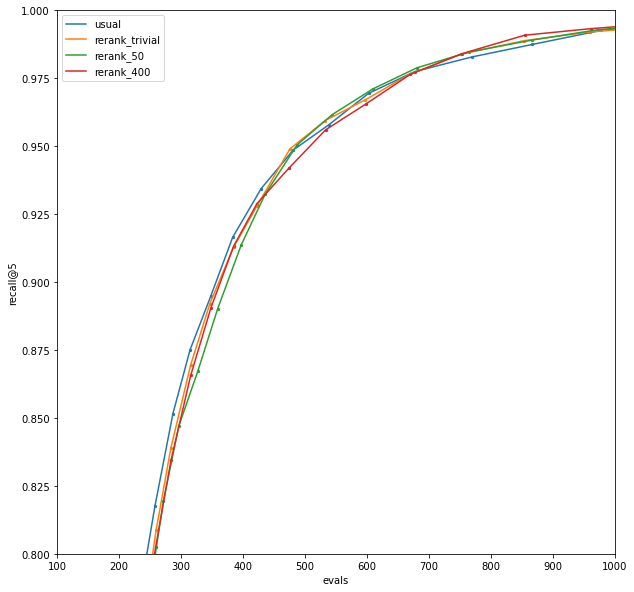

In [153]:
plot_chosen_results(
    results, x_log_scale=False,
    ylim=[0.8, 1], xlim=[100, 1000],
    keys=[
        "usual",
        "rerank_trivial",
#         "rerank_greedy",
        "rerank_50",
        "rerank_400"
    ]
)